In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import glob


#### Step 1: Define Paths and Parameters

In [2]:
train_dir = os.path.join('Dataset', 'images.cv_jzk6llhf18tm3k0kyttxz', 'data', 'train')
test_dir = os.path.join('Dataset', 'images.cv_jzk6llhf18tm3k0kyttxz', 'data', 'test')
val_dir = os.path.join('Dataset', 'images.cv_jzk6llhf18tm3k0kyttxz', 'data', 'val')

In [3]:
# Define image size
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

#### Step 2: Create Data Generators

In [4]:
# Targeted augumetation script for 'animal fish bass'
# This step addresses the issue: 'animal fish bass' class had very few images, so the model failed to learn this class well.

# Define the path to the 'animal fish bass' class directory
bass_src_dir = os.path.join('Dataset', 'images.cv_jzk6llhf18tm3k0kyttxz', 'data', 'train', 'animal fish bass')
augment_count_per_image = 10  

bass_augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Filter out already augmented images
all_files = glob.glob(os.path.join(bass_src_dir, '*'))
original_images = [img for img in all_files if '_aug_' not in os.path.basename(img)]

print(f"Found {len(original_images)} original bass images. Starting augmentation...")

for img_path in original_images:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    i = 0
    for batch in bass_augmentor.flow(x, batch_size=1, save_to_dir=bass_src_dir, save_prefix=f"{base_name}_aug", save_format='jpg'):
        i += 1
        if i >= augment_count_per_image:
            break

print("Bass augmentation completed!")

Found 30 original bass images. Starting augmentation...
Bass augmentation completed!


In [5]:
# For training: apply data augmentation and rescaling.

train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    rotation_range=20,             # Random rotations up to 20 degrees
    zoom_range=0.2,                # Random zoom in/out
    horizontal_flip=True,          # Random horizontal flip
    width_shift_range=0.1,         # Random horizontal shifts
    height_shift_range=0.1,        # Random vertical shifts
    shear_range=0.15,               # Random shear transformations
    vertical_flip=True,            # Random vertical flip
    fill_mode='nearest',           # Fill mode for new pixels
    brightness_range=[0.9, 1.1],   # Random brightness adjustments
    channel_shift_range=0.2        # Random channel shifts
)

In [6]:
# For validation and test sets: only rescaling.

val_test_datagen = ImageDataGenerator(rescale=1./255)

#### Step 3: Load Images from Directories

In [7]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 7422 images belonging to 11 classes.


In [8]:
# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1092 images belonging to 11 classes.


In [9]:
# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3187 images belonging to 11 classes.


#### Step 4: Inspect the Loaded Data

In [10]:
print("Train Class Indices:", train_generator.class_indices)
print("Validation Class Indices:", val_generator.class_indices)
print("Test Class Indices:", test_generator.class_indices)

Train Class Indices: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}
Validation Class Indices: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}
Test Class Indices: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
class_count = len(train_generator.class_indices)
class_count

11

#### Step 5: Build a Deeper CNN Model from scratch.

In [13]:
# used Flatten()

# model = Sequential([
#     # Input Layer
#     Input(shape=(img_height, img_width, 3)),

#     # Block 1
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # Block 2
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # Block 3
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # Block 4
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # Fully Connected Layers
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(class_count, activation='softmax')
# ])

In [14]:
# used GlobalAveragePooling2D()

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

c:\python_VSC\GUVI_Projects\guvi_projects_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Print model summary to inspect the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,315,371 (5.02 MB)

 Trainable params: 1,312,427 (5.01 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# Define Early Stopping Callback 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
 
class_weights = dict(enumerate(class_weights))

In [49]:
class_weights

{0: 0.6156270736562708,
 1: 0.5498999777728384,
 2: 1.185812430100655,
 3: 1.1920976549951814,
 4: 1.1775345073774393,
 5: 1.1653320772491758,
 6: 1.1816589715013532,
 7: 1.2541399121324772,
 8: 1.1714015151515151,
 9: 1.2335050689712481,
 10: 1.1633228840125391}

In [19]:
# Train the Model with Early Stopping
epochs = 20
import math

steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps, epochs=epochs, callbacks=[early_stopping], class_weight=class_weights)
# history = model.fit(train_generator,validation_data=val_generator,epochs=epochs,callbacks=[early_stopping],class_weight=class_weights)

c:\python_VSC\GUVI_Projects\guvi_projects_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1095s 5s/step - accuracy: 0.4538 - loss: 1.7171 - val_accuracy: 0.1053 - val_loss: 16.4325
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1140s 5s/step - accuracy: 0.7192 - loss: 0.7997 - val_accuracy: 0.3462 - val_loss: 2.9062
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1072s 5s/step - accuracy: 0.7983 - loss: 0.5199 - val_accuracy: 0.5375 - val_loss: 1.5837
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1083s 5s/step - accuracy: 0.8514 - loss: 0.3643 - val_accuracy: 0.6145 - val_loss: 1.9721
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1142s 5s/step - accuracy: 0.8834 - loss: 0.2912 - val_accuracy: 0.9075 - val_loss: 0.2494
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1143s 5s/step - accuracy: 0.9021 - loss: 0.2419 - val_accuracy: 0.5952 - val_loss: 1.8717
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1115s 5s/step - accuracy: 0.9165 - loss: 0.2104 - val_accuracy: 0.5229 - val_loss: 2.8834
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1117s 5s/step - accuracy: 0.9270 - loss: 0.1742 -

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%") 

100/100 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9575 - loss: 0.1292
Test Accuracy: 97.46%


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_and_print_report(model, model_name, test_generator):
    print(f"\n Evaluation for {model_name}:\n")

    # Predict
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # True labels & class names
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    class_indices = list(test_generator.class_indices.values())

    # Classification Report
    print("Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred, labels=class_indices))

    # Return metrics for final comparison table
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

results = []


In [22]:
results.append(evaluate_and_print_report(model, "CNN", test_generator))


 Evaluation for CNN:

100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 888ms/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.96      0.97       520
                animal fish bass       0.08      0.08      0.08        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       0.98      0.86      0.91       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.99      0.99      0.99       273
          fish sea_food sea_bass       0.88      1.00      0.94       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                     

In [23]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.suptitle(f'"{model_name}" - Training History', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


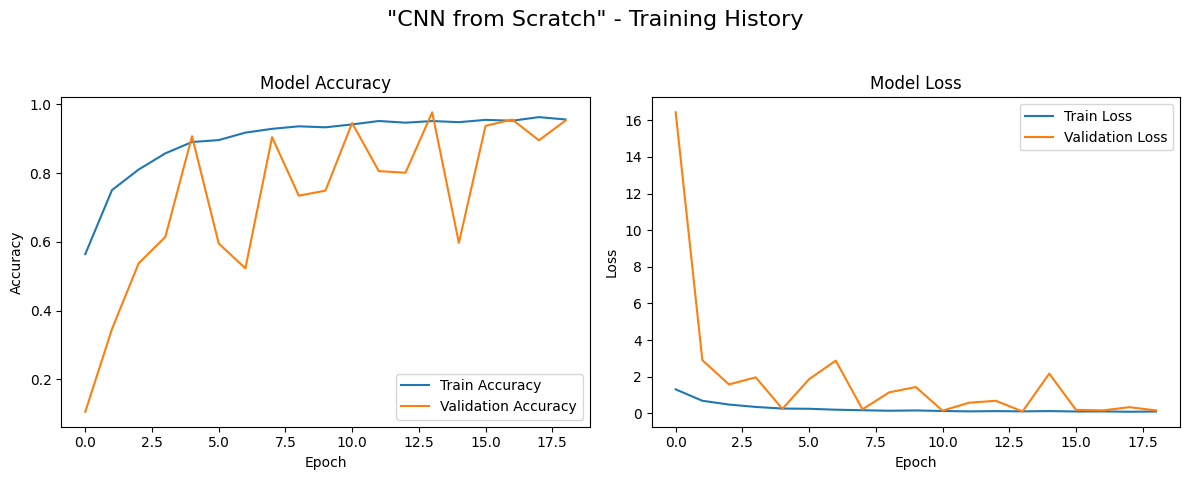

In [24]:
plot_history(history, "CNN from Scratch")

In [25]:
import os

os.makedirs('models', exist_ok=True)
model.save('models/cnn_fish_model.h5')

#### Step 6: Transfer Learning with five pre-trained models (e.g., VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0).

In [40]:
# Image generators for InceptionV3 only
inception_train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

inception_val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

inception_test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7422 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
# Transfer Learning with Pre-trained Models

from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_model(base_model_class, model_name, train_gen, val_gen, input_shape=(224, 224, 3), class_count=3, epochs=20):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_gen,validation_data=val_gen,epochs=epochs,callbacks=[early_stopping])

    os.makedirs('models', exist_ok=True)
    model.save(f"models/{model_name}_fish_model.h5")
    print(f"{model_name} model saved!")

    return model, history

##### VGG16

In [ ]:
# VGG16
vgg_model, vgg_history = build_and_train_model(VGG16, "VGG16", train_generator, val_generator, (img_height, img_width, 3), class_count)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,843 (56.64 MB)

 Trainable params: 134,155 (524.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training vgg_history...
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1149s 5s/step - accuracy: 0.3235 - loss: 1.9368 - val_accuracy: 0.7234 - val_loss: 1.1007
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1111s 5s/step - accuracy: 0.6589 - loss: 1.0299 - val_accuracy: 0.8278 - val_loss: 0.6628
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1115s 5s/step - accuracy: 0.7629 - loss: 0.7217 - val_accuracy: 0.8736 - val_loss: 0.5014
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1107s 5s/step - accuracy: 0.8144 - loss: 0.5616 - val_accuracy: 0.9139 - val_loss: 0.3668
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1114s 5s/step - accuracy: 0.8376 - loss: 0.4828 - val_accuracy: 0.8892 - val_loss: 0.3428
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1117s 5s/step - accuracy: 0.8608 - loss: 0.4115 - val_accuracy: 0.9350 - val_loss: 0.2638
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1109s 5s/step - accuracy: 0.8777 - loss: 0.3641 - val_accuracy: 0.9386 - val_loss: 0.2435
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1103s 5s/step - accuracy: 

vgg_history model saved!


In [29]:
# Evaluate VGG16 Model
results.append(evaluate_and_print_report(vgg_model, "VGG16", test_generator))


 Evaluation for VGG16:

100/100 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.98      0.99       520
                animal fish bass       0.56      0.77      0.65        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       0.98      0.99      0.99       305
   fish sea_food hourse_mackerel       0.99      0.98      0.98       286
        fish sea_food red_mullet       0.95      0.96      0.95       291
     fish sea_food red_sea_bream       1.00      0.98      0.99       273
          fish sea_food sea_bass       1.00      0.97      0.98       327
            fish sea_food shrimp       0.96      0.99      0.98       289
fish sea_food striped_red_mullet       0.93      0.92      0.93       293
             fish sea_food trout       1.00      0.99      1.00       292

                     

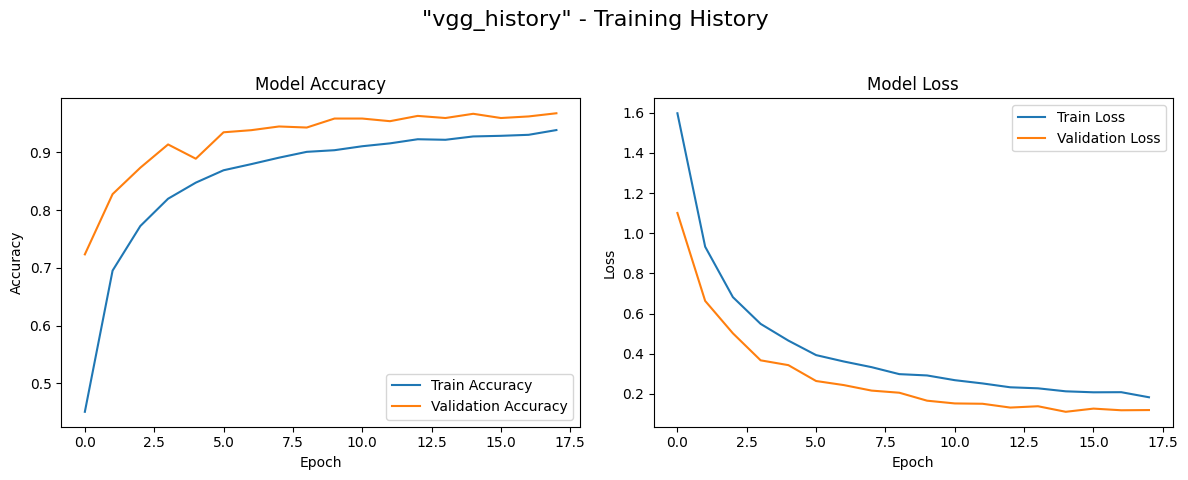

In [30]:
# Visualize Training History
plot_history(vgg_history, "vgg_history")

##### ResNet50

In [32]:
# ResNet50
resnet_model, resnet_history = build_and_train_model(ResNet50, "ResNet50", train_generator, val_generator, (img_height, img_width, 3), class_count)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,115,083 (91.99 MB)

 Trainable params: 527,371 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50...
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.1526 - loss: 2.4492 - val_accuracy: 0.0092 - val_loss: 2.4014
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.1960 - loss: 2.1853 - val_accuracy: 0.1337 - val_loss: 2.2499
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2018 - loss: 2.1246 - val_accuracy: 0.1291 - val_loss: 2.2308
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.2201 - loss: 2.0754 - val_accuracy: 0.2134 - val_loss: 2.1369
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.2247 - loss: 2.0361 - val_accuracy: 0.2335 - val_loss: 2.0964
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.2362 - loss: 2.0065 - val_accuracy: 0.2143 - val_loss: 2.0908
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.2650 - loss: 1.9716 - val_accuracy: 0.2317 - val_loss: 2.0412
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.2439 - lo

ResNet50 model saved!


In [33]:
# Evaluate ResNet50 Model
results.append(evaluate_and_print_report(resnet_model, "ResNet50", test_generator))


 Evaluation for ResNet50:

100/100 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       0.44      0.23      0.30       520
                animal fish bass       0.04      0.85      0.08        13
   fish sea_food black_sea_sprat       0.33      0.40      0.36       298
   fish sea_food gilt_head_bream       0.26      0.05      0.08       305
   fish sea_food hourse_mackerel       0.33      0.68      0.44       286
        fish sea_food red_mullet       0.34      0.41      0.37       291
     fish sea_food red_sea_bream       0.44      0.14      0.22       273
          fish sea_food sea_bass       0.63      0.04      0.07       327
            fish sea_food shrimp       0.36      0.72      0.48       289
fish sea_food striped_red_mullet       0.13      0.11      0.12       293
             fish sea_food trout       0.47      0.59      0.52       292

                  

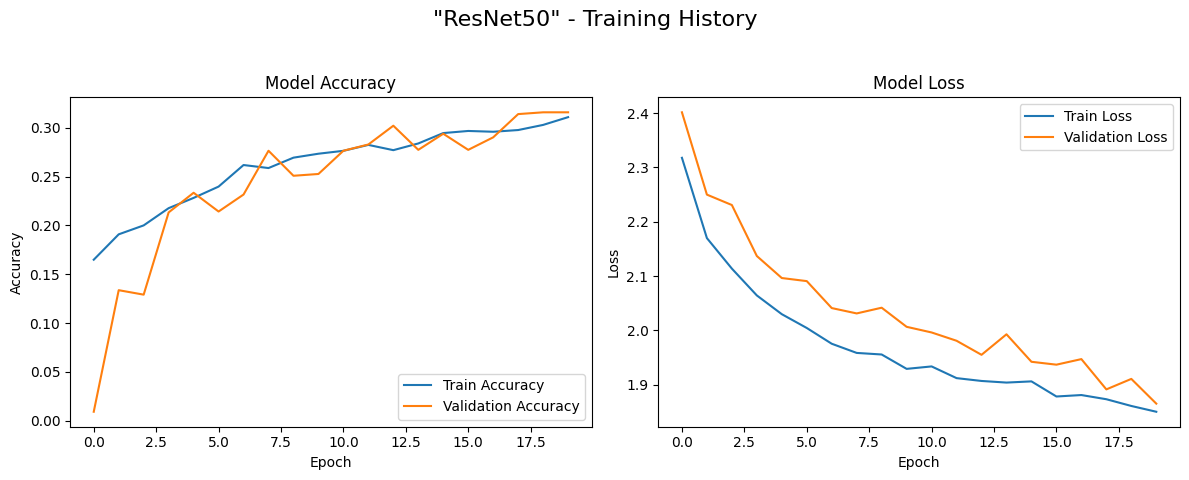

In [34]:
# Visualize Training History
plot_history(resnet_history, "ResNet50")

##### MobileNetV2

In [35]:
# MobileNetV2
mobilenet_model, mobilenet_history = build_and_train_model(MobileNetV2, "MobileNetV2", train_generator, val_generator, (img_height, img_width, 3), class_count)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training MobileNetV2...
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 202s 857ms/step - accuracy: 0.6821 - loss: 0.9485 - val_accuracy: 0.9734 - val_loss: 0.0888
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 195s 839ms/step - accuracy: 0.9462 - loss: 0.1705 - val_accuracy: 0.9789 - val_loss: 0.0626
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9549 - loss: 0.1283 - val_accuracy: 0.9771 - val_loss: 0.0586
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9682 - loss: 0.0926 - val_accuracy: 0.9835 - val_loss: 0.0498
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 210s 904ms/step - accuracy: 0.9702 - loss: 0.0853 - val_accuracy: 0.9899 - val_loss: 0.0349
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 209s 902ms/step - accuracy: 0.9758 - loss: 0.0710 - val_accuracy: 0.9863 - val_loss: 0.0364
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9768 - loss: 0.0678 - val_accuracy: 0.9872 - val_loss: 0.0423
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accura

MobileNetV2 model saved!


In [36]:
# Evaluate MobileNetV2 Model
results.append(evaluate_and_print_report(mobilenet_model, "MobileNetV2", test_generator))


 Evaluation for MobileNetV2:

100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 787ms/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      0.99       520
                animal fish bass       0.89      0.62      0.73        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       1.00      0.99      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

             

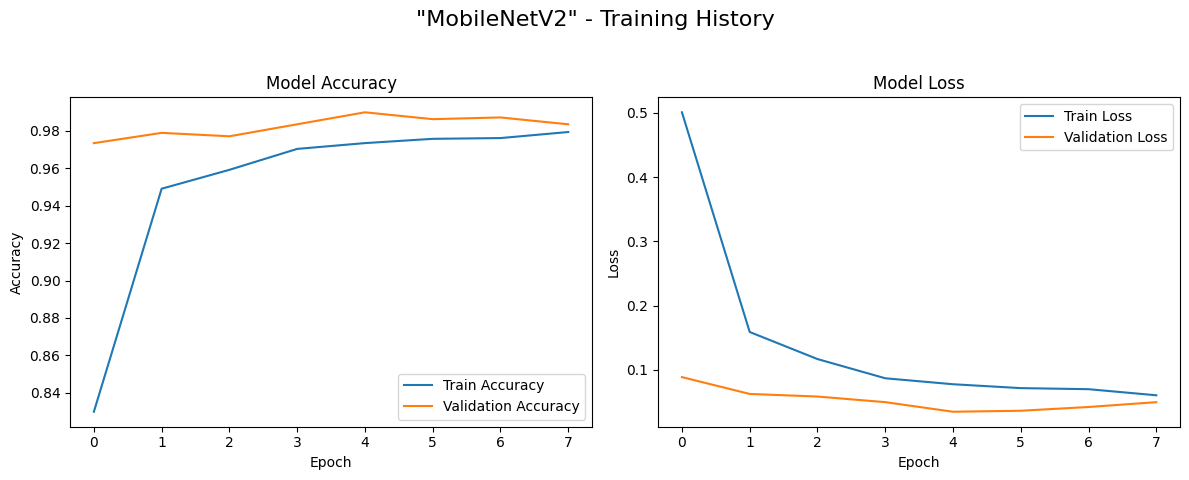

In [37]:
# Visualize Training History
plot_history(mobilenet_history, "MobileNetV2")

##### InceptionV3

In [38]:
# InceptionV3 (requires 299x299 image input)
inception_model, inception_history = build_and_train_model(InceptionV3, "InceptionV3", inception_train_gen, inception_val_gen, (299, 299, 3), class_count)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,330,155 (85.18 MB)

 Trainable params: 527,371 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Training InceptionV3...


c:\python_VSC\GUVI_Projects\guvi_projects_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - accuracy: 0.6228 - loss: 1.1561 - val_accuracy: 0.9542 - val_loss: 0.1897
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.9057 - loss: 0.2929 - val_accuracy: 0.9661 - val_loss: 0.1100
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.9294 - loss: 0.2107 - val_accuracy: 0.9808 - val_loss: 0.0748
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 609s 3s/step - accuracy: 0.9381 - loss: 0.1815 - val_accuracy: 0.9863 - val_loss: 0.0506
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.9525 - loss: 0.1438 - val_accuracy: 0.9881 - val_loss: 0.0500
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - accuracy: 0.9595 - loss: 0.1225 - val_accuracy: 0.9881 - val_loss: 0.0385
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9622 - loss: 0.1159 - val_accuracy: 0.9881 - val_loss: 0.0410
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9646 - loss: 0.1053 - val_accu

InceptionV3 model saved!


In [41]:
# Evaluate InceptionV3 Model
results.append(evaluate_and_print_report(inception_model, "InceptionV3", inception_test_gen))


 Evaluation for InceptionV3:

100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       1.00      0.98      0.99       520
                animal fish bass       0.67      0.92      0.77        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      0.99      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

               

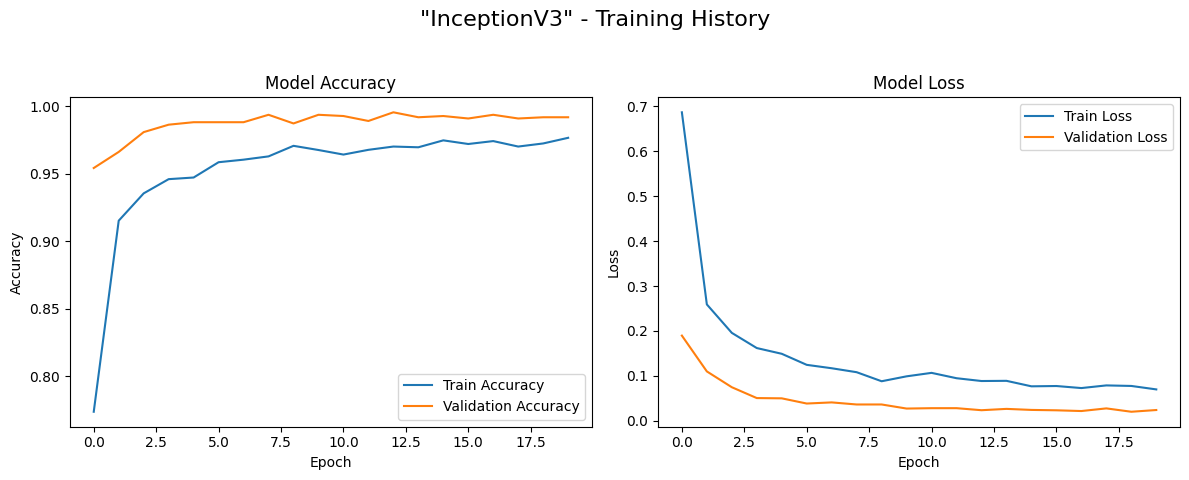

In [42]:
# Visualize Training History
plot_history(inception_history, "InceptionV3")

##### EfficientNetB0

In [43]:
# EfficientNetB0
efficientnet_model, efficientnet_history = build_and_train_model(EfficientNetB0, "EfficientNetB0", train_generator, val_generator, (img_height, img_width, 3), class_count)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,380,334 (16.71 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training EfficientNetB0...
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.1357 - loss: 2.4020 - val_accuracy: 0.0092 - val_loss: 2.4357
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.1558 - loss: 2.3674 - val_accuracy: 0.0092 - val_loss: 2.4416
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.1592 - loss: 2.3571 - val_accuracy: 0.0092 - val_loss: 2.4195
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.1594 - loss: 2.3596 - val_accuracy: 0.0092 - val_loss: 2.4235
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.1671 - loss: 2.3527 - val_accuracy: 0.0092 - val_loss: 2.4438
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.1567 - loss: 2.3578 - val_accuracy: 0.0092 - val_loss: 2.4344


EfficientNetB0 model saved!


In [44]:
# Evaluate EfficientNetB0 Model
results.append(evaluate_and_print_report(efficientnet_model, "EfficientNetB0", test_generator))


 Evaluation for EfficientNetB0:

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step
Classification Report
                                  precision    recall  f1-score   support

                     animal fish       0.00      0.00      0.00       520
                animal fish bass       0.00      1.00      0.01        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

            

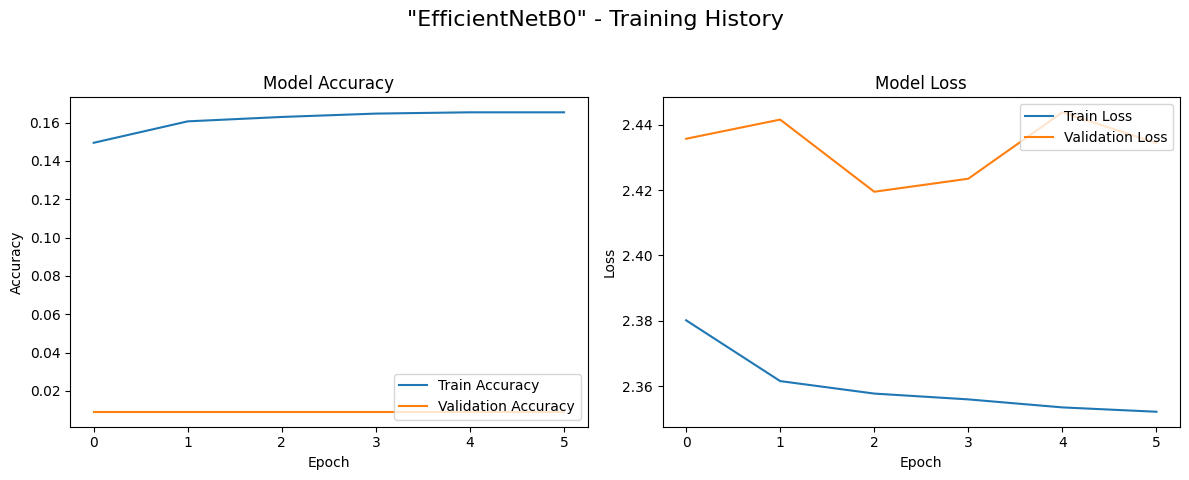

In [45]:
# Visualize Training History
plot_history(efficientnet_history, "EfficientNetB0")

#### Step 7: Finding best model 

In [46]:
import pandas as pd

df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.sort_values(by='F1-Score', ascending=False)

print("\n Model Comparison Table:\n")
print(df_metrics)


 Model Comparison Table:

            Model  Accuracy  Precision    Recall  F1-Score
3     MobileNetV2  0.995921   0.995804  0.995921  0.995755
4     InceptionV3  0.994980   0.995512  0.994980  0.995149
1           VGG16  0.976467   0.977326  0.976467  0.976737
0             CNN  0.974584   0.975916  0.974584  0.974480
2        ResNet50  0.325698   0.379563  0.325698  0.292473
5  EfficientNetB0  0.004079   0.000017  0.004079  0.000033


In [47]:
best_model_row = df_metrics.iloc[0]
best_model_name = best_model_row['Model']

print(f"\n Best Performing Model: {best_model_name}")


 Best Performing Model: MobileNetV2


In [48]:
os.makedirs('best_model', exist_ok=True)
csv_path = os.path.join('best_model', 'best_model_name.csv')

import csv

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['best cnn model', best_model_name])

print(f"\n Best model name saved to: {csv_path}")


 Best model name saved to: best_model\best_model_name.csv


In [ ]:
import os
import logging
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path to the model folder
model_dir = 'models'

# List all .h5 files in the models folder
model_files = [f for f in os.listdir(model_dir) if f.endswith('.h5')]

# Loop over each model and evaluate
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    print(f"\n Evaluating model: {model_file}")
    
    # Load and optionally compile the model (optional but clean)
    model = load_model(model_path)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Evaluate on the test set
    if model_file == 'InceptionV3_fish_model.h5':
        test_loss, test_accuracy = model.evaluate(inception_test_gen, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



 Evaluating model: cnn_fish_model.h5
Test Accuracy: 97.46%

 Evaluating model: EfficientNetB0_fish_model.h5
Test Accuracy: 0.41%

 Evaluating model: InceptionV3_fish_model.h5
Test Accuracy: 99.50%

 Evaluating model: MobileNetV2_fish_model.h5
Test Accuracy: 99.59%

 Evaluating model: ResNet50_fish_model.h5
Test Accuracy: 32.57%

 Evaluating model: VGG16_fish_model.h5
Test Accuracy: 97.65%
